In [74]:
# Default imports to work with scipy and matplotlib
import numpy as np
from scipy.optimize import minimize,linprog
import matplotlib.pyplot as plt
%matplotlib inline

# Power generation grid optimization

We want to optimize the production of *green* electrical power from 3 kinds of power generators (hydro-based, solar-based and wind-based). The maximum power production of solar and wind generators depends on their primary energy source, on the contrary to hydro generators which have constant maximum power of 5kW per generator. We have predictions for available solar and wind power for the next day:

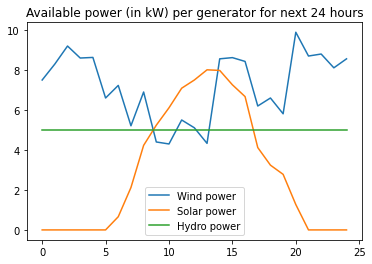

In [75]:
# Global parameters
n = 25   # number of hours (from 0 to n both included)

# Input generators data
hours = np.linspace(0,n-1,n) # 1 data point per hour starting from 0 to n, both included

#Given maximum power production of each energy source
wind = np.array([7.5,8.3,9.2,8.6,8.63,6.6,7.23,5.21,6.9,4.4,4.3,5.5,5.11,4.33,8.56,8.62,8.43,6.2,6.6,5.81,9.89,8.7,8.8,8.11,8.56]) # in kW
solar = np.array([0,0,0,0,0,0,0.66,2.12,4.23,5.24,6.11,7.09,7.5,8.01,7.98,7.26,6.67,4.12,3.24,2.78,1.27,0,0,0,0])
hydro = np.array([5 for i in range(n)])

# Input data plot
plt.figure()
plt.plot(hours,wind,label="Wind power")
plt.plot(hours,solar,label="Solar power")
plt.plot(hours,hydro,label="Hydro power")
plt.title("Available power (in kW) per generator for next 24 hours")
plt.legend()
plt.show()

Our current power generation grid is based on 12 hydro generators, 10 solar generators and 8 wind generators.

Each kind of generator has specific costs (in euros) and operational constraints (in kW) when used. Some simplified assumptions were done for cost to obtain the following characteristics:

| Type | max power | cost/kWh     |
|------|-----------|--------------|
|Hydro |    5      |          2   |
|Solar |    8      |          1.5 |
|Wind  |    10     |          1.1 |


In fact, we want to define, per hour, which of the available generators we want to use.

We have to satisfy the following demand:


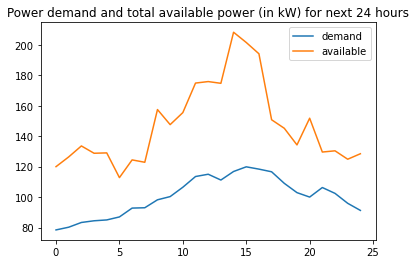

In [76]:
n_h = 12 # Number of hydro generators
n_s = 10 # Number of solar generators
n_w = 8  # Number of wind generators


demand = np.array([78.45,80.23,83.34,84.45,85.01,86.98,92.78,93.01,98.23,100.34,106.48,113.52,115.02,111.21,116.82,119.89,118.38,116.63,109.04,102.94,100.02,106.29,102.45,95.93,91.26])

plt.figure()
plt.plot(hours,demand,label='demand')
plt.plot(hours,wind*n_w+solar*n_s+hydro*n_h,label='available')
plt.title("Power demand and total available power (in kW) for next 24 hours")
plt.legend()
plt.show()

## Optimization of current grid

We want to minimize the production cost for the demand of next 24 hours.

### 1. Define the mathematical optimization problem for only deciding the next hour of production

## Mathematical expression of the problem

### Constraints
##### Maximum power by each type of generator
    #Hydro <= hydro_max_next_hr * n_h
    #Solar <= hydro_max_next_hr * n_s
    #Wind  <= wind_max_next_hr * n_w
#### Must meet the demand
    #V.Hydro + V.Solar + V.Wind >= demand_next_hr
#### Global: each electicity power generated must not be less than 0


### Objective
#### Minimize this total cost equation: 
    #(V.Hydro * 2) + (V.Solar * 1.5) + (V.Wind * 1.1)
  
  
### Parameters
    #Demand each hour
    #Maximum power of each type of generator
    #Cost per kWh

### Variables
    #Total power generated by each type of power generator
    
### Return
    #Total power generated by each type of power generator and their summation
    #Minimum cost to meet demand

### 2. Solve it for the first hour and validate your model

In [77]:
#initialize i = 0
i = 16

#Pull parameters of each next hour
demand_next_hr = demand[i]
hydro_max_next_hr = hydro[i]
solar_max_next_hr = solar[i]
wind_max_next_hr = wind[i]


#Constraints
#Maximum power by each type of generator
    #Hydro <= hydro_max_next_hr * n_h
    #Solar <= hydro_max_next_hr * n_s
    #Wind  <= wind_max_next_hr * n_w
#Must meet the demand
    #V.Hydro + V.Solar + V.Wind >= demand_next_hr
#Global: each one not less than 0

#Objective
    #minimize[(V.Hydro * 2) + (V.Solar * 1.5) + (V.Wind * 1.1)]

#c is the matrix of cost of each type of generator per kWh. The order is hydro, solar, and wind respectively
c = [2.0, 1.5, 1.1]

#A is the matrix of coefficeint in fornt of hydro, solar, and wind power respectively in relation to the constraints
#the order is max power of 1) hydro, 2) solar, 3) wind, then 4) demand, and >= 0 constaint for 5),6), and 7) 
#The 4th, 5th, 6th, and 7th element's sign is reverted to represent >= constraint of demand
A = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [-1, -1, -1], [-1, 0, 0], [0, -1, 0], [0, 0, -1]]

#b is the matrix of the right size of the constraint equations, order is similar to A, the sign of 4th right side vectore element is also reverted 
b = [hydro_max_next_hr * n_h, solar_max_next_hr * n_s, wind_max_next_hr * n_w, -demand_next_hr, 0, 0, 0]

#Use linprog to find solutions
fx = linprog(c,A,b)

#Find out how many generator we have to run where fraction mean running another generator at a certain % power
if hydro_max_next_hr <= 0:
    num_hydro = 0
else:
    num_hydro = fx.x[0]/hydro_max_next_hr

if solar_max_next_hr <= 0:
    num_solar = 0
else:
    num_solar = fx.x[1]/solar_max_next_hr
    
if wind_max_next_hr <= 0:
    num_wind = 0
else:
    num_wind = fx.x[2]/wind_max_next_hr

#Print results
print(
    "Linprog method solutions for the hour ", i," :\n",
    "Hydro geenrators produce ", fx.x[0], " kWh  using ", num_hydro, " generators\n",
    "Solar geenrators produce ", fx.x[1], " kWh  using ", num_solar, " generators\n",
    "Wind geenrators produce ", fx.x[2], " kWh  using ", num_wind, " generators\n",
    "Produce total of ", fx.x[0]+fx.x[1]+fx.x[2], "in respond to the demand of ",demand_next_hr, " kWh",  "\n",
    "Total cost to generate power of this hour is", fx.fun, "euros", "\n")

Linprog method solutions for the hour  16  :
 Hydro geenrators produce  4.9266899725319896e-08  kWh  using  9.853379945063979e-09  generators
 Solar geenrators produce  50.93999992374539  kWh  using  7.637181397862877  generators
 Wind geenrators produce  67.43999993841503  kWh  using  7.999999992694547  generators
 Produce total of  118.37999991142732 in respond to the demand of  118.38  kWh 
 Total cost to generate power of this hour is 150.59399991640842 euros 



### 3. Define and solve the problem over the 24 hours step by step


In [78]:
#Repeat the steps in 2. however this time we use for loop to find solution of each hour from 0 to 24
for i in range(n):

    demand_next_hr = demand[i]
    hydro_max_next_hr = hydro[i]
    solar_max_next_hr = solar[i]
    wind_max_next_hr = wind[i]


    #Constraints
    #Maximum power by each type of generator
        #Hydro <= hydro_max_next_hr * n_h
        #Solar <= hydro_max_next_hr * n_s
        #Wind  <= wind_max_next_hr * n_w
    #Must meet the demand
        #V.Hydro + V.Solar + V.Wind >= demand_next_hr
    #Global: each one not less than 0

    #Objective
        #minimize[(V.Hydro * 2) + (V.Solar * 1.5) + (V.Wind * 1.1)]
    
    c = [2.0, 1.5, 1.1]
    A = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [-1, -1, -1], [-1, 0, 0], [0, -1, 0], [0, 0, -1]]
    b = [hydro_max_next_hr * n_h, solar_max_next_hr * n_s, wind_max_next_hr * n_w, -demand_next_hr, 0, 0, 0]

    fx = linprog(c,A,b)

    if hydro_max_next_hr <= 0:
        num_hydro = 0
    else:
        num_hydro = fx.x[0]/hydro_max_next_hr

    if solar_max_next_hr <= 0:
        num_solar = 0
    else:
        num_solar = fx.x[1]/solar_max_next_hr
    
    if wind_max_next_hr <= 0:
        num_wind = 0
    else:
        num_wind = fx.x[2]/wind_max_next_hr


    print(
    "Linprog method solutions for the hour ", i," :\n",
    "Hydro geenrators produce ", fx.x[0], " kWh  using ", num_hydro, " generators\n",
    "Solar geenrators produce ", fx.x[1], " kWh  using ", num_solar, " generators\n",
    "Wind geenrators produce ", fx.x[2], " kWh  using ", num_wind, " generators\n",
    "Produce total of ", fx.x[0]+fx.x[1]+fx.x[2], "to meet demand of ",demand_next_hr, " kWh",  "\n"
    "Total cost to generate power of this hour is", fx.fun, "euros", "\n")

Linprog method solutions for the hour  0  :
 Hydro geenrators produce  18.449999998295983  kWh  using  3.6899999996591966  generators
 Solar geenrators produce  0.0  kWh  using  0  generators
 Wind geenrators produce  59.99999999334183  kWh  using  7.999999999112244  generators
 Produce total of  78.44999999163781 to meet demand of  78.45  kWh 
Total cost to generate power of this hour is 102.899999989268 euros 

Linprog method solutions for the hour  1  :
 Hydro geenrators produce  13.829999995801344  kWh  using  2.765999999160269  generators
 Solar geenrators produce  0.0  kWh  using  0  generators
 Wind geenrators produce  66.39999996920639  kWh  using  7.999999996289926  generators
 Produce total of  80.22999996500774 to meet demand of  80.23  kWh 
Total cost to generate power of this hour is 100.69999995772973 euros 

Linprog method solutions for the hour  2  :
 Hydro geenrators produce  9.740000046265308  kWh  using  1.9480000092530616  generators
 Solar geenrators produce  0.0  

Previous assumptions are too basic to be realistics. In fact, the production costs are not linearly dependents on the power production. Then we consider the following functions to compute the cost from the produced power:

- hydro: $cost_h(power) = 0.88*log(1.18+power)$
- solar: $cost_s(power) = 0.05*exp(0.47*power)$
- wind: $cost_w(power)=0.0012*power^3+0.042$

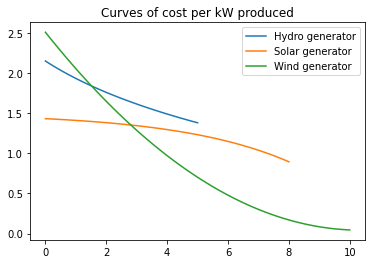

In [79]:
from numpy import log,exp
cost_h=lambda x: 3.27-0.88*log(3.58+x)
cost_s=lambda x: 1.5-0.07*exp(0.27*x)
cost_w=lambda x: 0.023*(x-10.35)**2+0.042
p_h = np.linspace(0,5,100)
p_s = np.linspace(0,8,100)
p_w = np.linspace(0,10,100)
c_h = cost_h(p_h)
c_s = cost_s(p_s)
c_w = cost_w(p_w)

plt.figure()
plt.plot(p_h,c_h,label="Hydro generator")
plt.plot(p_s,c_s,label="Solar generator")
plt.plot(p_w,c_w,label="Wind generator")
plt.title("Curves of cost per kW produced")
plt.legend()
plt.show()


### 4. Define a new model integrating these new cost functions and solve it for all the periods

In [80]:
hydro_gen_lst = [0 for i in range(n_h)] #make a list of x0 of 12 hydro generators
solar_gen_lst = [0 for i in range(n_s)] #make a list of x0 of 10 solar generators
wind_gen_lst = [0 for i in range(n_w)] #make a list of x0 of 8 wind generators

#Number of hydro, solar, wind generators: n_h = 12, n_s = 10, n_w = 8

#combine them together into one list
All_gen_lst = hydro_gen_lst + solar_gen_lst + wind_gen_lst

#print(All_gen_lst, "\n")

#convert the list to np.array
all_gen_arr = np.array(All_gen_lst)
#print(len(all_gen_arr))

#define objective function to minimize total cost
def cost_hydro(x):
    return sum(cost_h(x[0: n_h]))

def cost_solar(x):
    return sum(cost_s(x[n_h: n_h + n_s]))

def cost_wind(x):
    return sum(cost_w(x[n_h + n_s: n_h + n_s + n_w]))

def cost_total(x):
    cost_total = cost_hydro(x) + cost_solar(x) + cost_wind(x)
    return cost_total

In [81]:
#create boundary condition
#bounday of each generator, meaning it must be >= 0
bnd = (0, None)
#create empthy list and use for loop to populate 30 boundaries; one for each generator
bounds = []
for z in range(n_h + n_s + n_w):
    bounds.insert(0, bnd)

#convert the list to tuple
bounds_tup = tuple(bounds)


#define constraints

#first, try with only one hour of interest
#pull demand and max power data from the given
i = 15
demand_next_hr = demand[i]
hydro_max_next_hr = hydro[i]
solar_max_next_hr = solar[i]
wind_max_next_hr = wind[i]

#to meet demand, >=
cons_demand = {'type': 'ineq', 'fun': lambda x: -np.sum(x) + demand_next_hr}
cons_demand = [cons_demand]

#constraint: max power of hydro generators, <=
cons_hydro = [{'type': 'ineq', 'fun': lambda x, j=j: x[j] - hydro_max_next_hr} for j in range(0, n_h)]
    
    
#constraint: max power of solar generators, <=
cons_solar = [{'type': 'ineq', 'fun': lambda x, j=j: x[j] - solar_max_next_hr} for j in range(n_h, n_h + n_s)]


#constraint: max power of wind generators, <=
cons_wind = [{'type': 'ineq', 'fun': lambda x, j=j: x[j] - wind_max_next_hr} for j in range(n_h + n_s, n_h + n_s + n_w)]

#combine all constraint into one
all_cons = cons_demand + cons_hydro + cons_solar + cons_wind

#print(all_cons)

In [82]:
#apply minimize function to find solution for the zero hour
res = minimize(cost_total, all_gen_arr, method='SLSQP', bounds=bounds_tup, constraints=all_cons)

print(
    "Minimize function solutions for the hour ", i," :\n",
    "Hydro geenrator #1 to #",n_h, " produce ", res.x[0:n_h], " kWh  respectively \n",
    "Solar geenrator #1 to #",n_s, " produce ", res.x[n_h:n_h + n_s], " kWh  respectively \n",
    "Wind geenrators #1 to #",n_w, " produce ", res.x[n_h + n_s:n_h + n_s + n_w], " kWh  respectively \n",
    "Produce total of ", sum(res.x), "to meet demand of ",demand[i], " kWh",  "\n"
    "Total cost to generate power of this hour is", res.fun, "euros", "\n")


Minimize function solutions for the hour  15  :
 Hydro geenrator #1 to # 12  produce  [2.97405239 2.97405239 2.97405239 2.97405239 2.97405239 2.97405239
 2.97405239 2.97405239 2.97405239 2.97405239 2.97405239 2.97405239]  kWh  respectively 
 Solar geenrator #1 to # 10  produce  [4.31832407 4.31832407 4.31832407 4.31832407 4.31832407 4.31832407
 4.31832407 4.31832407 4.31832407 4.31832407]  kWh  respectively 
 Wind geenrators #1 to # 8  produce  [5.12726632 5.12726632 5.12726632 5.12726632 5.12726632 5.12726632
 5.12726632 5.12726632]  kWh  respectively 
 Produce total of  119.89000000784054 to meet demand of  119.89  kWh 
Total cost to generate power of this hour is 37.49500268059162 euros 



In [83]:
#apply the solution to the hour 0 to 24

for i in range(25):
    demand_next_hr = demand[i]
    hydro_max_next_hr = hydro[i]
    solar_max_next_hr = solar[i]
    wind_max_next_hr = wind[i]
    
    #to meet demand, >=
    cons_demand = {'type': 'ineq', 'fun': lambda x: -np.sum(x) + demand_next_hr}
    cons_demand = [cons_demand]

    #constraint: max power of hydro generators, <=
    cons_hydro = [{'type': 'ineq', 'fun': lambda x, j=j: x[j] - hydro_max_next_hr} for j in range(0, n_h)]
    
    
    #constraint: max power of solar generators, <=
    cons_solar = [{'type': 'ineq', 'fun': lambda x, j=j: x[j] - solar_max_next_hr} for j in range(n_h, n_h + n_s)]


    #constraint: max power of wind generators, <=
    cons_wind = [{'type': 'ineq', 'fun': lambda x, j=j: x[j] - wind_max_next_hr} for j in range(n_h + n_s, n_h + n_s + n_w)]
    
    #combine all constraint into one
    all_cons = cons_demand + cons_hydro + cons_solar + cons_wind
    
    res = minimize(cost_total, all_gen_arr, method='SLSQP', bounds=bounds_tup, constraints=all_cons)

    print(
    "Minimize function solutions for the hour ", i," :\n",
    "Hydro generator #1 to #",n_h, " produce ", res.x[0:n_h], " kWh  respectively \n",
    "Solar generator #1 to #",n_s, " produce ", res.x[n_h:n_h + n_s], " kWh  respectively \n",
    "Wind generators #1 to #",n_w, " produce ", res.x[n_h + n_s:n_h + n_s + n_w], " kWh  respectively \n",
    "Produce total of ", sum(res.x), "to meet demand of ",demand_next_hr, " kWh",  "\n"
    "Total cost to generate power of this hour is", res.fun, "euros", "\n")

Minimize function solutions for the hour  0  :
 Hydro generator #1 to # 12  produce  [3.26875 3.26875 3.26875 3.26875 3.26875 3.26875 3.26875 3.26875 3.26875
 3.26875 3.26875 3.26875]  kWh  respectively 
 Solar generator #1 to # 10  produce  [0.00000000e+00 0.00000000e+00 6.48439635e-15 1.39471767e-15
 2.17464935e-14 6.48439635e-15 6.48439635e-15 0.00000000e+00
 1.39471767e-15 0.00000000e+00]  kWh  respectively 
 Wind generators #1 to # 8  produce  [4.903125 4.903125 4.903125 4.903125 4.903125 4.903125 4.903125 4.903125]  kWh  respectively 
 Produce total of  78.45000000000582 to meet demand of  78.45  kWh 
Total cost to generate power of this hour is 39.01685571200157 euros 

Minimize function solutions for the hour  1  :
 Hydro generator #1 to # 12  produce  [3.17365506 3.17365506 3.17365506 3.17365506 3.17365506 3.17365506
 3.17365506 3.17365506 3.17365506 3.17365506 3.17365506 3.17365506]  kWh  respectively 
 Solar generator #1 to # 10  produce  [1.83537576e-13 9.71191664e-14 0.000

Minimize function solutions for the hour  12  :
 Hydro generator #1 to # 12  produce  [3.26984307 3.26984307 3.26984307 3.26984307 3.26984307 3.26984307
 3.26984307 3.26984307 3.26984307 3.26984307 3.26984307 3.26984307]  kWh  respectively 
 Solar generator #1 to # 10  produce  [4.90476461 4.90476461 4.90476461 4.90476461 4.90476461 4.90476461
 4.90476461 4.90476461 4.90476461 4.90476461]  kWh  respectively 
 Wind generators #1 to # 8  produce  [3.34177962 3.34177962 3.34177962 3.34177962 3.34177962 3.34177962
 3.34177962 3.34177962]  kWh  respectively 
 Produce total of  115.02000000168862 to meet demand of  115.02  kWh 
Total cost to generate power of this hour is 40.661713026153244 euros 

Minimize function solutions for the hour  13  :
 Hydro generator #1 to # 12  produce  [3.18215635 3.18215635 3.18215635 3.18215635 3.18215635 3.18215635
 3.18215635 3.18215635 3.18215635 3.18215635 3.18215635 3.18215635]  kWh  respectively 
 Solar generator #1 to # 10  produce  [5.09781447 5.09781

## Power grid improvement (optional)

We want to study the possibility to buy a battery system to store some power when possible. This will allow to satisfy power demand when solar and wind are not enough available and hydro power alone is not enough. Moreover, it reduces the risk to not satisfy the demand in case of a generator failure. Batteries can have various capacities. From a market study, we consider that 2500 euros per kWh is a relevant average price. The battery technology have a lifetime of about 18 months, considering hourly charge and discharge cycles. The electric components used to store the power (between the generators and the battery system and from the battery and the power delivery sink) have a global efficiency of 88%.

This new battery within the grid may allow to shutdown the most expensive generators when enough power has been stored. Nevertheless, we want to keep at least 25kWh in the battery at the end of the 24 hours. With historical data about wind and solar conditions, we have globally excellent production conditions about 22% of the time (ie. >75% of maximum power) and bad conditions about 15% of the time (ie <30% of maximum power). The demand given for 24h can be considered of an average demand over the year. Season effects are neglected in this analysis.


### 1. Define the mathematical problem allowing to size battery storage and solve it

### 2. Update your previous model to optimize the energy production taking into account this new battery


## 1. Mathematical expression of the problem

### Constraints
##### Maximum power by each generator of each type
    #Hydro #1 to #12 <= hydro_max_next_hr
    #Solar #1 to #10 <= hydro_max_next_hr
    #Wind #1 to #8 <= wind_max_next_hr
#### Must meet the demand with battery
    #V.Hydro + V.Solar + V.Wind + V.Battery >= demand_next_hr
#### Global: each electicity power generated from renewable sources and the battery must not be less than 0


#### Battery constraint at the 24th hour
    #V.Battery_available <= charged power in the battery at the beginning of the hour
    #V.Battery >= 25 (when n = 25)
        #If already more than 25: V.Battery <= Available power - 25
        #If less than 25: 0.88*(total capacity of solar and wind - (demand - power supplied by hydro)) >= Available power + 25 


### Objective
#### Minimize this total cost equation: 
    #cost_h(V.hydro) + cost_s(V.solar) + cost_w(V.Wind) + V.Battery(no cost)
  
  
### Parameters
    #Demand each hour
    #Maximum power of each type of generator
    #Cost per kWh

### Variables
    #Total power generated by each type of power generator
    #Power charged available inside the battery at the end of each hour
    
### Return
    #Total power generated by each type of power generator and their summation
    #Minimum cost to meet demand
    #Power charged to the battery at the end of each hour
    #Total cost when include charging of battery at each hour
    #Recommended battery size

In [84]:

#define demand constraint, >=
cons_demand_with_bat = {'type': 'ineq', 'fun': lambda x: -np.sum(x) + demand_next_hr}
cons_demand_with_bat = tuple([cons_demand_with_bat])

#Initialize V.Battery & charged power
battery_gen_lst = [0]
charged_power = 0

#combine existing power generation list with the new battery
All_gen_lst_with_bat = hydro_gen_lst + solar_gen_lst + wind_gen_lst + battery_gen_lst

#convert the list to np.array
all_gen_arr_with_bat = np.array(All_gen_lst_with_bat)

#Copy the existing list of boudary and add one more element to it
bounds_with_bat = bounds.copy()
bounds_with_bat.insert(0, bnd)
bounds_tup_with_bat = tuple(bounds_with_bat)

battery_size = 0

for i in range(25):
    demand_next_hr = demand[i]
    hydro_max_next_hr = hydro[i]
    solar_max_next_hr = solar[i]
    wind_max_next_hr = wind[i]

    #constraint: max power of hydro generators, <=
    cons_hydro = [{'type': 'ineq', 'fun': lambda x, j=j: x[j] - hydro_max_next_hr} for j in range(0, n_h)]
    
    
    #constraint: max power of solar generators, <=
    cons_solar = [{'type': 'ineq', 'fun': lambda x, j=j: x[j] - solar_max_next_hr} for j in range(n_h, n_h + n_s)]


    #constraint: max power of wind generators, <=
    cons_wind = [{'type': 'ineq', 'fun': lambda x, j=j: x[j] - wind_max_next_hr} for j in range(n_h + n_s, n_h + n_s + n_w)]

    #constraint: max power from battery, <=    
    if i == 24:
        #power in batter already more than 25, it can be drawn out as much as 25 kWh remianed
        if charged_power > 25:
            cons_bat = [{'type': 'ineq', 'fun': lambda x: x[n_h + n_s + n_w] - (0.88*charged_power) + (0.88*25)}]
        
        #less than 25, we reserve the power generated by solar and wind to charge battery by subtract them with (demand + power generated by hydro)
        else:
            cons_bat = [{'type': 'ineq', 'fun': lambda x: -0.88*(sum(res.x[n_h:n_h + n_s]) + sum(res.x[n_h + n_s:n_h + n_s + n_w]) - (demand_next_hr - sum(res.x[0,n_h]))) + charged_power + 25}]
    else:
        #other hours, we make sure that battery cannot be overdrawn
        cons_bat = [{'type': 'ineq', 'fun': lambda x: x[n_h + n_s + n_w] - (0.88*charged_power)}]
    
    #combine all constraint into one
    all_cons_with_bat = cons_demand + cons_hydro + cons_solar + cons_wind + cons_bat
    
    res = minimize(cost_total, all_gen_arr_with_bat, method='SLSQP', bounds=bounds_tup_with_bat, constraints=all_cons_with_bat)
    
    #Subtract power drawn from the available at the begining
    remained = charged_power - res.x[n_h + n_s + n_w]/0.88
    
    #Recharge using solar and wind (assum all remaining capacity is used to charge battery)
    charged_power = remained + (0.88*((solar_max_next_hr*n_s) + (wind_max_next_hr*n_w) - sum(res.x[n_h:n_h + n_s]) - sum(res.x[n_h + n_s:n_h + n_s + n_w])))
    
    #Calculate total cost of the hour include the cost to recharge (surprisingly, it is usually less than not charging becasue of lower cost at higher running rate)
    total_cost_include_charging = sum(cost_h(res.x[0:n_h])) + cost_s(solar_max_next_hr)*n_s + cost_w(wind_max_next_hr)*n_w
          
    print(
    "Minimize function solutions for the hour ", i," :\n",
    "To meet the demand\n",
    "Hydro geenrator #1 to #",n_h, " produce ", res.x[0:n_h], " kWh  respectively \n",
    "Solar geenrator #1 to #",n_s, " produce ", res.x[n_h:n_h + n_s], " kWh  respectively \n",
    "Wind geenrators #1 to #",n_w, " produce ", res.x[n_h + n_s:n_h + n_s + n_w], " kWh  respectively \n",
    "Produce total power of ", sum(res.x), "to meet demand of ",demand_next_hr, " kWh",  "\n",
    "with ", sum(res.x) - res.x[n_h + n_s + n_w], " kWh generated by generators", "\n",
    "and ", res.x[n_h + n_s + n_w], " kWh from the battery (or ", res.x[n_h + n_s + n_w]/0.88, " drawn if efficiency is 100%)", "\n\n"
    "Available power inside the battery after usage is ", remained, "kWh", "\n",
    "Available power inside the battery after charge is ", charged_power, "kWh", "\n",   
    "The cost to generate power of this hour to meet demand is", res.fun, "euros", "\n",
    "The cost to recharge the battery is ", total_cost_include_charging - res.fun, "euros", "\n",
    "Therefore, the total cost is is", total_cost_include_charging, "euros", "\n")
    
    #To see how big the battery we need to collect all possible power from solar and wind
    if battery_size < charged_power:
        battery_size = charged_power
        

print("Recommended Battery Size is ", battery_size, "kWh")

Minimize function solutions for the hour  0  :
 To meet the demand
 Hydro geenrator #1 to # 12  produce  [3.26875 3.26875 3.26875 3.26875 3.26875 3.26875 3.26875 3.26875 3.26875
 3.26875 3.26875 3.26875]  kWh  respectively 
 Solar geenrator #1 to # 10  produce  [1.08733876e-16 1.45699125e-16 1.90668561e-21 2.19630950e-16
 3.05964287e-16 9.26035092e-17 1.45404302e-16 3.40008875e-15
 1.69969285e-16 3.41231266e-15]  kWh  respectively 
 Wind geenrators #1 to # 8  produce  [4.903125 4.903125 4.903125 4.903125 4.903125 4.903125 4.903125 4.903125]  kWh  respectively 
 Produce total power of  78.45000000007572 to meet demand of  78.45  kWh 
 with  78.45000000007572  kWh generated by generators 
 and  1.1107489712713595e-16  kWh from the battery (or  1.2622147400810904e-16  drawn if efficiency is 100%) 

Available power inside the battery after usage is  -1.2622147400810904e-16 kWh 
 Available power inside the battery after charge is  18.281999999967127 kWh 
 The cost to generate power of this 

Minimize function solutions for the hour  7  :
 To meet the demand
 Hydro geenrator #1 to # 12  produce  [2.80868394 2.80868394 2.80868394 2.80868394 2.80868394 2.80868394
 2.80868394 2.80868394 2.80868394 2.80868394 2.80868394 2.80868394]  kWh  respectively 
 Solar geenrator #1 to # 10  produce  [1.19088199 1.19088199 1.19088199 1.19088199 1.19088199 1.19088199
 1.19088199 1.19088199 1.19088199 1.19088199]  kWh  respectively 
 Wind geenrators #1 to # 8  produce  [2.92664866 2.92664866 2.92664866 2.92664866 2.92664866 2.92664866
 2.92664866 2.92664866]  kWh  respectively 
 Produce total power of  93.01000000243386 to meet demand of  93.01  kWh 
 with  69.02621640806805  kWh generated by generators 
 and  23.983783594365796  kWh from the battery (or  27.25429953905204  drawn if efficiency is 100%) 

Available power inside the battery after usage is  21.263618748232616 kWh 
 Available power inside the battery after charge is  45.514650671466114 kWh 
 The cost to generate power of this ho

Minimize function solutions for the hour  16  :
 To meet the demand
 Hydro geenrator #1 to # 12  produce  [1.64661306 1.64661306 1.64661306 1.64661306 1.64661306 1.64661306
 1.64661306 1.64661306 1.64661306 1.64661306 1.64661306 1.64661306]  kWh  respectively 
 Solar geenrator #1 to # 10  produce  [2.19658182 2.19658182 2.19658182 2.19658182 2.19658182 2.19658182
 2.19658182 2.19658182 2.19658182 2.19658182]  kWh  respectively 
 Wind geenrators #1 to # 8  produce  [2.77618962 2.77618962 2.77618962 2.77618962 2.77618962 2.77618962
 2.77618962 2.77618962]  kWh  respectively 
 Produce total power of  118.3799999999981 to meet demand of  118.38  kWh 
 with  63.93469188458641  kWh generated by generators 
 and  54.4453081154117  kWh from the battery (or  61.86966831296784  drawn if efficiency is 100%) 

Available power inside the battery after usage is  125.99981306296428 kWh 
 Available power inside the battery after charge is  205.16871811565915 kWh 
 The cost to generate power of this ho